# Direct Capacity Coupling

---

### 0.1 Prerequisite

- When changing the python class in the lib directory please restart kernel.
- When launching the jupyter notebook please always firstly run this cell.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import constants
import scipy.sparse.linalg
import scipy.sparse as sparse
import qutip.settings as settings
from tqdm import tqdm
import qutip as qt

qt.settings.atol = 1e-100
qt.settings.auto_tidyup_atol = qt.settings.atol
current_dir = os.getcwd()

# Get the parent folder path
parent_dir = os.path.dirname(current_dir)

# Add the parent folder path to sys.path
sys.path.append(parent_dir)

from lib.qubit import qubit
from lib.circuit_cap_coupling import circuit_cap

plt.style.use("dark_background")
thememap = 'viridis'

# Setting up constants
h = constants.h
hbar = constants.hbar
pi = np.pi

---

The system is composed of two Transmon coupled by a capacitor. The nodes are defined as the graph below :

(ADD GRAPH)

#### Table of content :
   1) Visualization of the Hamiltonian
   2) Getting the interaction Matrix
   3) Varying the coupling parameter with system variable

### 1 Visualization of the Hamiltonian

In [2]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 1.2e-15
Ej_p = 9e9
Ej_t = 8e9
Cp = 150e-15
Ct = 170e-15
ncut_p = 20
ncut_t = 20

# Creation of circuit object
system_1 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], ng, ncut_t)])

system_1.print_params()

Ejp:    9.000000000000002 GHz
Ecp:    0.12913486216439415 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 69.69458014012218
w_probe:    2.9138875699824016 GHz
ng probe:    0.5
Ejt:    8.000000000000002 GHz
Ec:    0.11394252543917131 GHz
Cjt:    170.0 fF
Ejt/Ect target: 70.21083628930828
w_target:    2.5810465724595764 GHz
ng target:    0.5
detunning:    0.33284099752282537 GHz
Cc:    1.2 fF


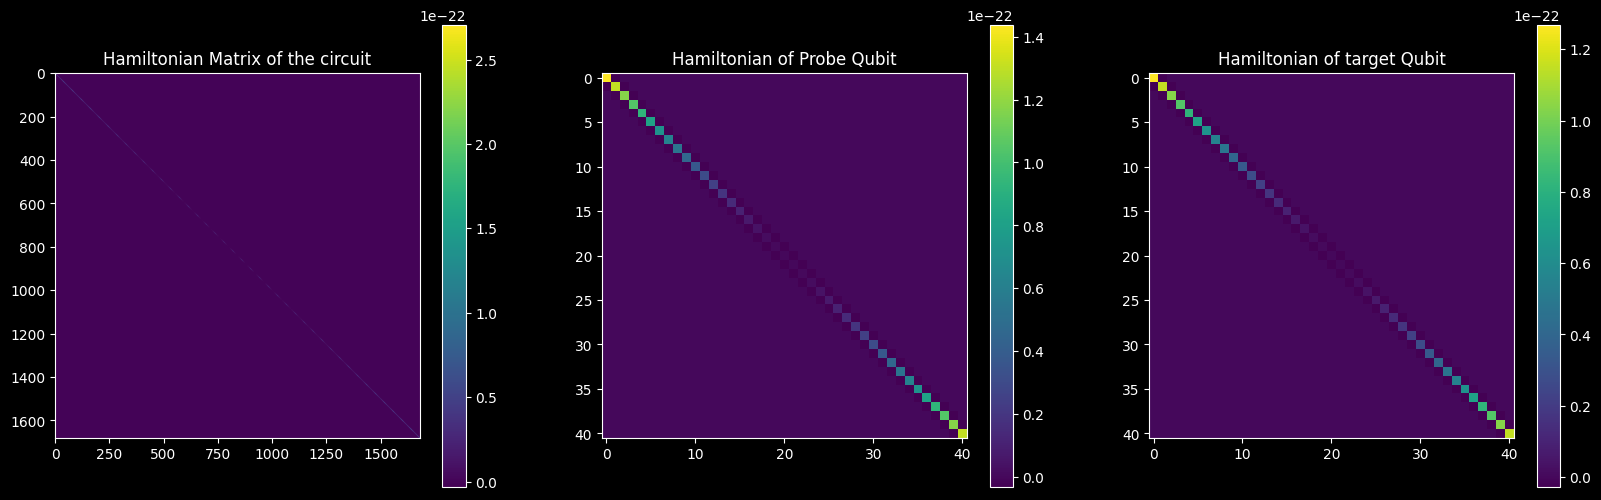

In [3]:
# Exctracting the Hamiltonian
H_circ = system_1.get_H_circuit()
H_p = system_1.get_H_probe()
H_t = system_1.get_H_target()

if type(H_circ) == scipy.sparse.csr_matrix:
    H_circ = H_circ.toarray()
    H_p = H_p.toarray()
    H_t = H_t.toarray()

f = plt.figure(figsize=(20,6))

# Plotting the Hamiltonian
ax1 = f.add_subplot(131)
ax1.title.set_text('Hamiltonian Matrix of the circuit')
im1 = ax1.imshow(np.real(H_circ), cmap=plt.get_cmap(thememap))
f.colorbar(im1)

ax2 = f.add_subplot(132)
ax2.title.set_text('Hamiltonian of Probe Qubit')
im2 = ax2.imshow(np.real(H_p), cmap=plt.get_cmap(thememap))
f.colorbar(im2)


ax3 = f.add_subplot(133)
ax3.title.set_text('Hamiltonian of target Qubit')
im3 = ax3.imshow(np.real(H_t), cmap=plt.get_cmap(thememap))
f.colorbar(im3)

ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

plt.show()

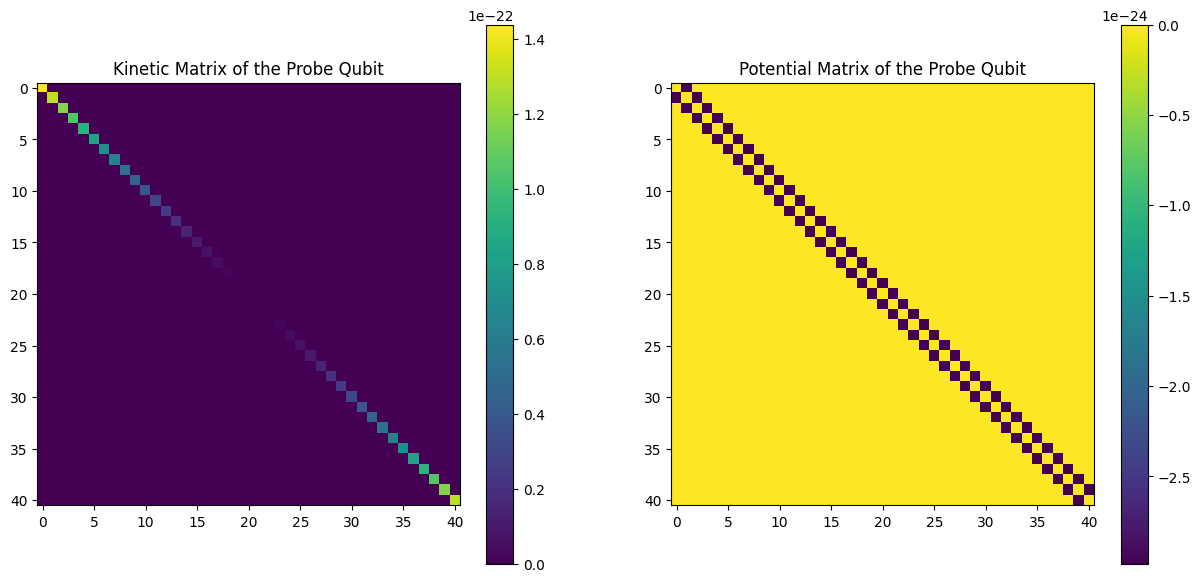

In [4]:
kin_probe = system_1.get_kinetic_probe()
pot_probe = system_1.get_potential_probe()

if type(kin_probe) == scipy.sparse.csr_matrix:
    kin_probe = kin_probe.toarray()
    pot_probe = pot_probe.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Kinetic Matrix of the Probe Qubit')
im1 = ax1.imshow(np.real(kin_probe), cmap=plt.get_cmap(thememap))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Potential Matrix of the Probe Qubit')
im2 = ax2.imshow(np.real(pot_probe), cmap=plt.get_cmap(thememap))
f.colorbar(im2)

ax1.grid(False)
ax2.grid(False)

plt.show()

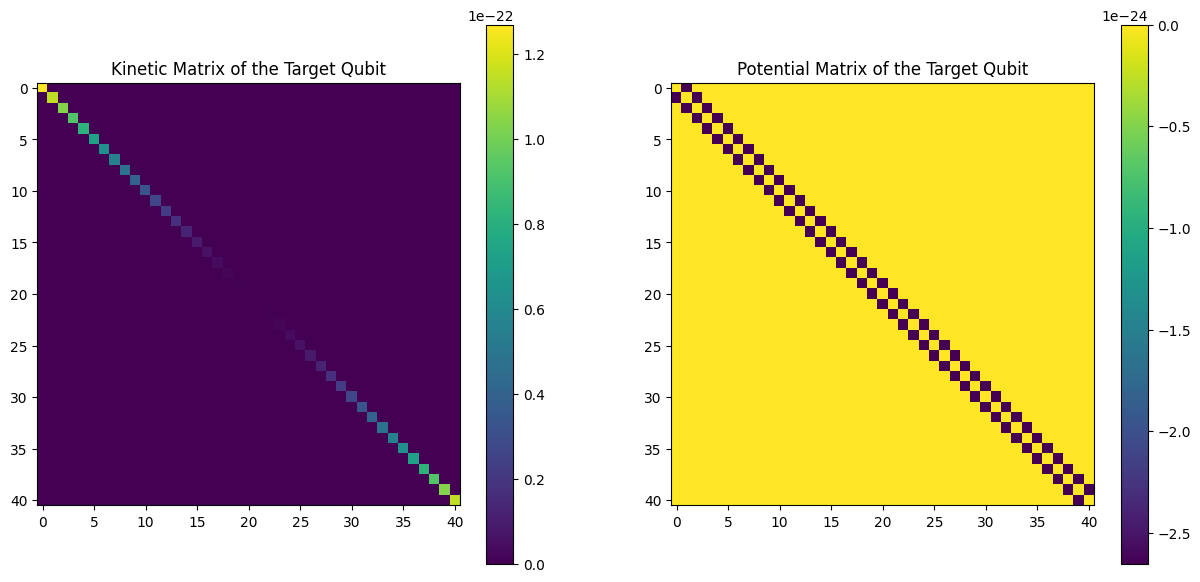

In [5]:
kin_target = system_1.get_kinetic_target()
pot_target = system_1.get_potential_target()

if type(kin_target) == scipy.sparse.csr_matrix:
    kin_target = kin_target.toarray()
    pot_target = pot_target.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Kinetic Matrix of the Target Qubit')
im1 = ax1.imshow(np.real(kin_target), cmap=plt.get_cmap(thememap))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Potential Matrix of the Target Qubit')
im2 = ax2.imshow(np.real(pot_target), cmap=plt.get_cmap(thememap))
f.colorbar(im2)
ax1.grid(False)
ax2.grid(False)
plt.show()

### 2 Calculate Interaction

#### 2.1 Static visualization

In [13]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 1.2e-15
Ej_p = 9e9
Ej_t = 8e9
Cp = 150e-15
Ct = 170e-15
ncut_p = 20
ncut_t = 20

# Creation of circuit object
system_2 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], ng, ncut_t)])

system_2.print_params()

Ejp:    9.000000000000002 GHz
Ecp:    0.12913486216439415 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 69.69458014012218
w_probe:    2.9138875715704087 GHz
ng probe:    0.5
Ejt:    8.000000000000002 GHz
Ec:    0.11394252543917131 GHz
Cjt:    170.0 fF
Ejt/Ect target: 70.21083628930828
w_target:    2.581046572459601 GHz
ng target:    0.5
detunning:    0.3328409991108075 GHz
Cc:    1.2 fF


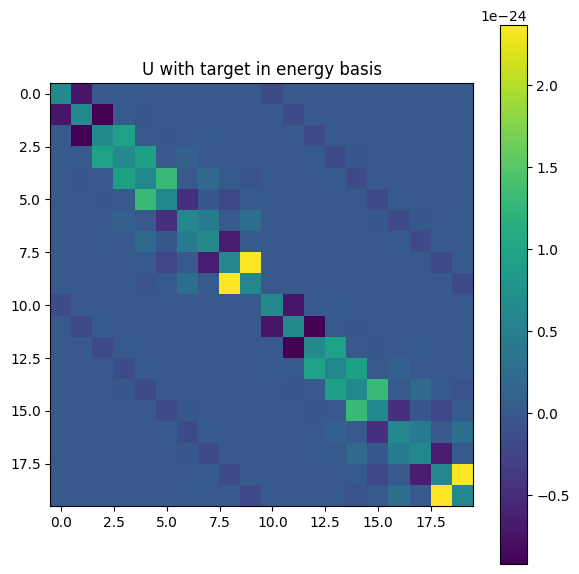

In [5]:
# U_ebcb = system_2.get_U_circuit()[0]
U_ebeb = system_2.get_U_circuit()[0]

# U_ebeb = U_ebeb.toarray()
# U_ebcb = U_ebcb.toarray()

# U_ebeb = U_ebeb.astype(float)
# U_ebcb = U_ebcb.astype(float)

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('U with target in energy basis')
im1 = ax1.imshow(U_ebeb, cmap=plt.get_cmap(thememap))
f.colorbar(im1)

# ax2 = f.add_subplot(122)
# ax2.title.set_text('U with target in charge basis')
# im2 = ax2.imshow(U_ebcb, cmap=plt.get_cmap(thememap))
# f.colorbar(im2)

ax1.grid(False)
# ax2.grid(False)

plt.show()

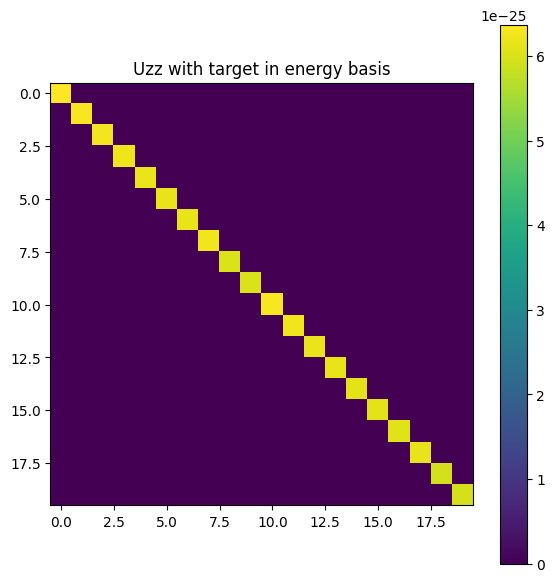

In [3]:
U_zz_ebeb = system_2.extract_U_zz()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Uzz with target in energy basis')
im1 = ax1.imshow(U_zz_ebeb, cmap=plt.get_cmap(thememap))
f.colorbar(im1)

ax1.grid(False)

plt.show()

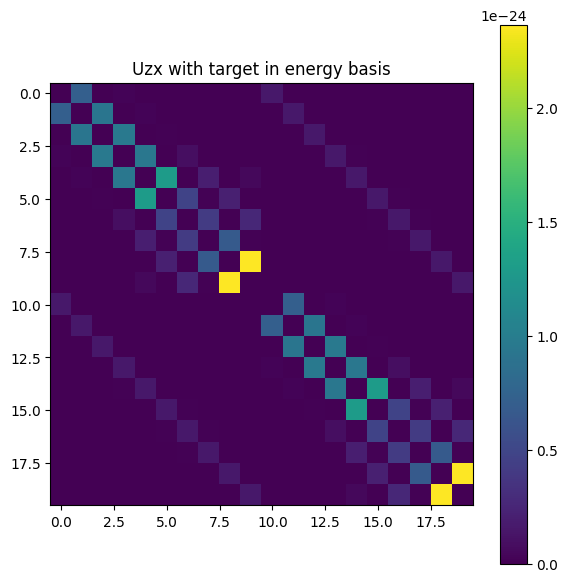

In [6]:
U_zx_ebeb = system_2.extract_U_zx()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Uzx with target in energy basis')
im1 = ax1.imshow(np.abs(U_zx_ebeb), cmap=plt.get_cmap(thememap))
f.colorbar(im1)

ax1.grid(False)

plt.show()

In [14]:
# The value of g_parr and g_perp are definied by the maximum of the precedent matrix
system_2.print_params()
print('g_parr = ', system_2.get_g_parr() * 1e-9/ constants.h, 'GHz')
print('g_perp = ', system_2.get_g_perp()  * 1e-9/ constants.h, 'GHz')
# print(system_2.test()[1]/constants.h, 'Hz')

Ejp:    9.000000000000002 GHz
Ecp:    0.12913486216439415 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 69.69458014012218
w_probe:    2.913887570033396 GHz
ng probe:    0.5
Ejt:    8.000000000000002 GHz
Ec:    0.11394252543917131 GHz
Cjt:    170.0 fF
Ejt/Ect target: 70.21083628930828
w_target:    2.581046572459603 GHz
ng target:    0.5
detunning:    0.3328409975737931 GHz
Cc:    1.2 fF
g_parr =  0.9620187403445188 GHz
g_perp =  1.1321225497811502 GHz


#### 2.2 Coupling regarding defining parameters (0 detuning)

##### Varying Cc

In [8]:
# Initialize transmon

# Circuit constant
ng = 0
Cc = 1.2e-15
Ej_p = 9e9
Ej_t = 8e9
Cp = 150e-15
Ct = 170e-15
ncut_p = 20
ncut_t = 20

# Creation of circuit object
system_3 = circuit_cap(Cc, [qubit(Ej_p, [Cp, Cc], ng, ncut_p), qubit(Ej_t, [Ct, Cc], ng, ncut_t)])

system_3.print_params()

Ejp:    9.000000000000002 GHz
Ecp:    0.12810998230594658 GHz
Cjp:    151.2 fF
Ejp/Ecp probe: 70.25213678124317
w_probe:    2.902865466550721 GHz
ng probe:    0
Ejt:    8.000000000000002 GHz
Ec:    0.11314386287768179 GHz
Cjt:    171.20000000000002 fF
Ejt/Ect target: 70.70644219252694
w_target:    2.5724243732272623 GHz
ng target:    0
detunning:    0.3304410933234588 GHz
Cc:    1.2 fF


100%|██████████| 100/100 [00:12<00:00,  7.76it/s]


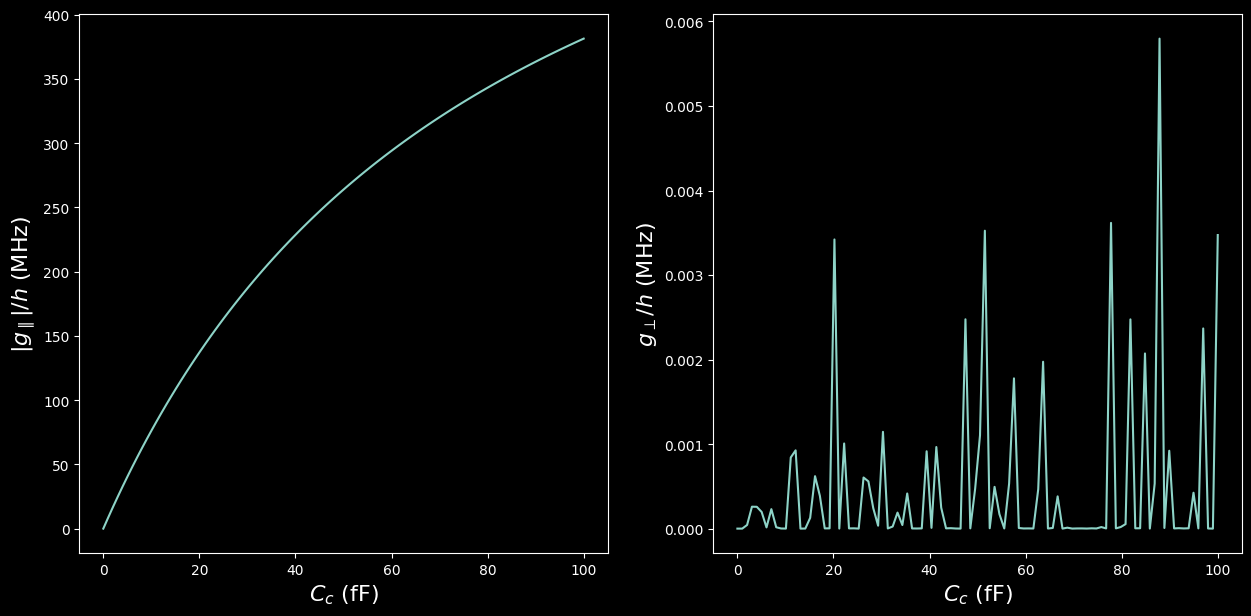

In [9]:
Ccs = np.linspace(0, 10e-14, 100)

fig_data_gparr = []
fig_data_gperp = []

for Cc in tqdm(Ccs):
    system_3.Cc = Cc

    # Full Hamiltonina Approach
    g_parr = system_3.get_g_parr(update=True)
    g_perp = system_3.get_g_perp()
    fig_data_gparr.append(g_parr)
    fig_data_gperp.append(g_perp)

pparam = dict(xlabel='$C_c$ (fF)', ylabel='$| g_\parallel | / h$ (MHz)')

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Ccs], [np.abs(g_parr) * 1e-6 / h for g_parr in fig_data_gparr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)
    pparam = dict(xlabel='$C_c$ (fF)', ylabel='$g_\\perp / h$ (MHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in Ccs], [np.abs(g_parr) * 1e-6 / h for g_parr in fig_data_gperp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)

    plt.show()

##### Varying Ej

In [4]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 20e-15
Ej_p = 9e9
Ej_t = 8e9
Cp = 150e-15
Ct = 170e-15
ncut_p = 20
ncut_t = 20

# Creation of circuit object
system_4 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], ng, ncut_t)])

system_4.print_params()

Ejp:    9.000000000000002 GHz
Ecp:    0.12913486216439415 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 69.69458014012218
w_probe:    2.913887570121124 GHz
ng probe:    0.5
Ejt:    8.000000000000002 GHz
Ec:    0.11394252543917131 GHz
Cjt:    170.0 fF
Ejt/Ect target: 70.21083628930828
w_target:    2.581046572459605 GHz
ng target:    0.5
detunning:    0.33284099766151903 GHz
Cc:    20.0 fF


100%|██████████| 100/100 [00:34<00:00,  2.89it/s]


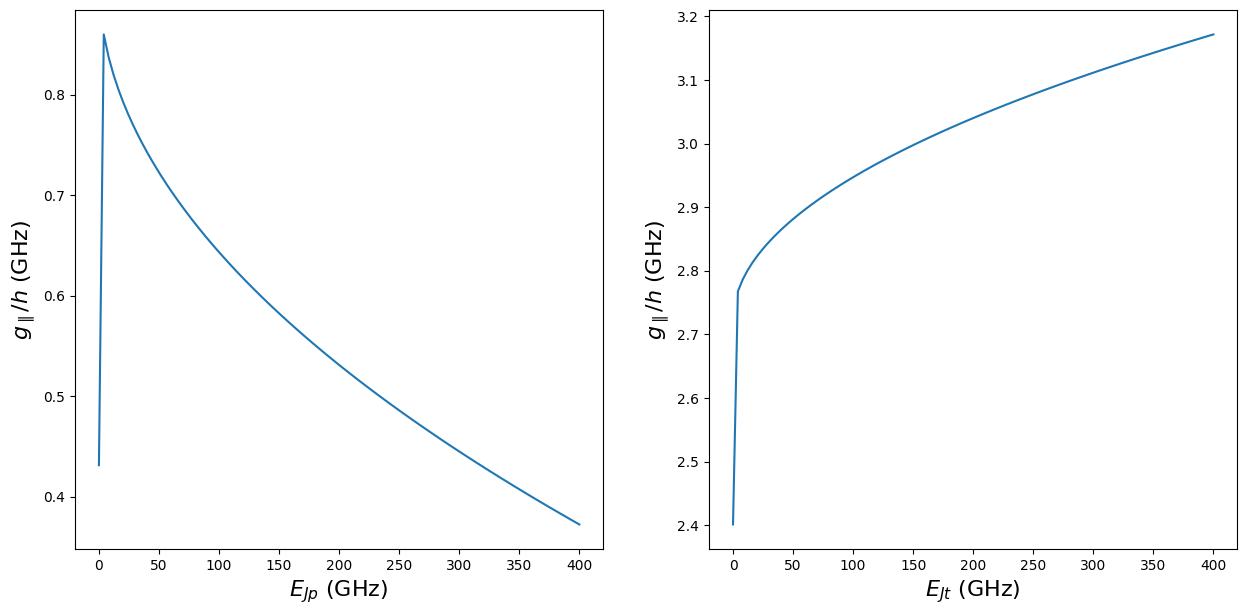

In [5]:
Ejps = np.linspace(0, 400e9, 100)
fig_data_Ejp_g_parr = []
Ejts = np.linspace(0, 400e9, 100)
fig_data_Ejt_g_parr = []

for Ejp in tqdm(Ejps):
    system_4.probe.Ej = Ejp*h
    
    g_parr = system_4.get_g_parr(update=True)
    fig_data_Ejp_g_parr.append(g_parr)
    
system_4.probe.Ej = 120e9
for Ejt in tqdm(Ejts):
    system_4.target.Ej = Ejt*h

    g_parr = system_4.get_g_parr(update=True)
    fig_data_Ejt_g_parr.append(g_parr)

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    pparam = dict(xlabel='$E_{Jp}$ (GHz)', ylabel='$g_\\parallel / h$ (GHz)')
    ax1.plot([val * 1e-9 for val in Ejps], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_data_Ejp_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)
    pparam = dict(xlabel='$E_{Jt}$ (GHz)', ylabel='$g_\\parallel / h$ (GHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e-9 for val in Ejts], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_data_Ejt_g_parr])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)

    plt.show()

##### Varying Ct and Cp

In [6]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 20e-15
Ej_p = 9e9
Ej_t = 8e9
Cp = 150e-15
Ct = 170e-15
ncut_p = 20
ncut_t = 20

# Creation of circuit object
system_5 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], ng, ncut_t)])

system_5.print_params()

Ejp:    9.000000000000002 GHz
Ecp:    0.12913486216439415 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 69.69458014012218
w_probe:    2.9138875719608883 GHz
ng probe:    0.5
Ejt:    8.000000000000002 GHz
Ec:    0.11394252543917131 GHz
Cjt:    170.0 fF
Ejt/Ect target: 70.21083628930828
w_target:    2.581046572459588 GHz
ng target:    0.5
detunning:    0.33284099950130025 GHz
Cc:    20.0 fF


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


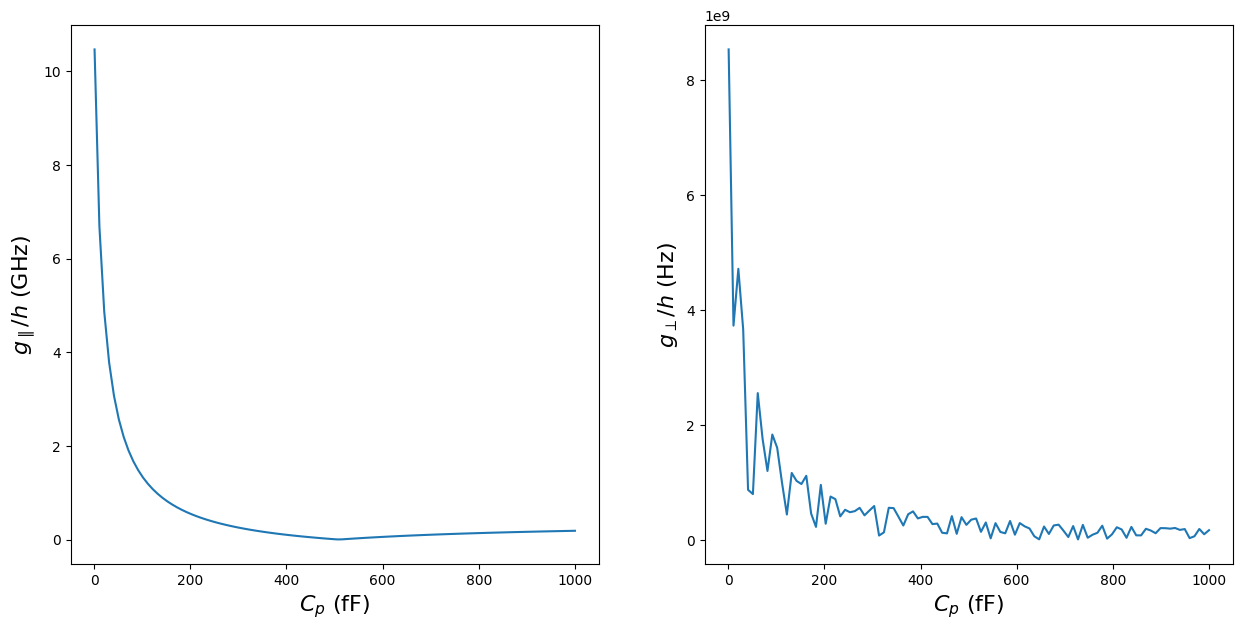

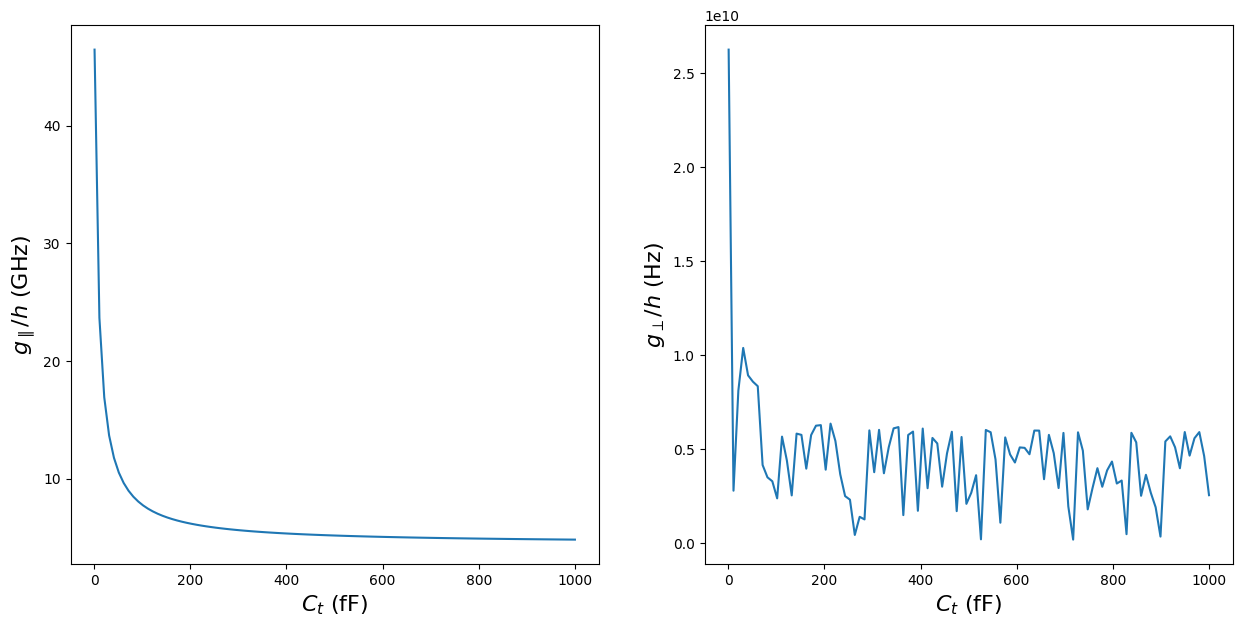

In [7]:
Cps = np.linspace(1e-15, 10e-13, 100)
fig_pt_detuning_Cp_g_parr = []
fig_pt_detuning_Cp_g_perp = []
fig_pt_detuning_Ct = np.linspace(1e-15, 10e-13, 100)
fig_pt_detuning_Ct_g_parr = []
fig_pt_detuning_Ct_g_perp = []

for Cp in tqdm(Cps):
    system_5.probe.C = Cp

    g_parr = system_5.get_g_parr(update=True)
    fig_pt_detuning_Cp_g_parr.append(g_parr)
    
    g_perp = system_5.get_g_perp()
    fig_pt_detuning_Cp_g_perp.append(g_perp)

system_5.probe.C = 12e-15

for Ct in tqdm(fig_pt_detuning_Ct):
    system_5.target.C = Ct

    g_parr = system_5.get_g_parr(update=True)
    fig_pt_detuning_Ct_g_parr.append(g_parr)
    
    g_perp = system_5.get_g_perp()
    fig_pt_detuning_Ct_g_perp.append(g_perp)

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    pparam = dict(xlabel='$C_{p}$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Cps], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Cp_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)

    pparam = dict(xlabel='$C_{p}$ (fF)', ylabel='$g_\\perp / h$ (Hz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in Cps], [np.abs(g_perp) / h for g_perp in fig_pt_detuning_Cp_g_perp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)
    plt.show()

pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ct_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)

    pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_\\perp / h$ (Hz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(g_perp) / h for g_perp in fig_pt_detuning_Ct_g_perp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)
    plt.show()


#### 2.3 Coupling regarding defining parameters (2 GHZ detuning)

##### Varying Cc

In [11]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 1.2e-15
Ej_p = 9e9
Ej_t = 4e9
Cp = 150e-15
Ct = 300e-15
ncut_p = 10
ncut_t = 10

# Creation of circuit object
system_6 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], 0, ncut_t)])

system_6.print_params()

Ejp:    9.000000000000002 GHz
Ecp:    0.12913486216439415 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 69.69458014012218
w_probe:    2.9138875699855924 GHz
ng probe:    0.5
Ejt:    4.000000000000001 GHz
Ec:    0.06456743108219708 GHz
Cjt:    300.0 fF
Ejt/Ect target: 61.95073790233083
w_target:    1.3695342034817153 GHz
ng target:    0
detunning:    1.544353366503877 GHz
Cc:    1.2 fF


100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


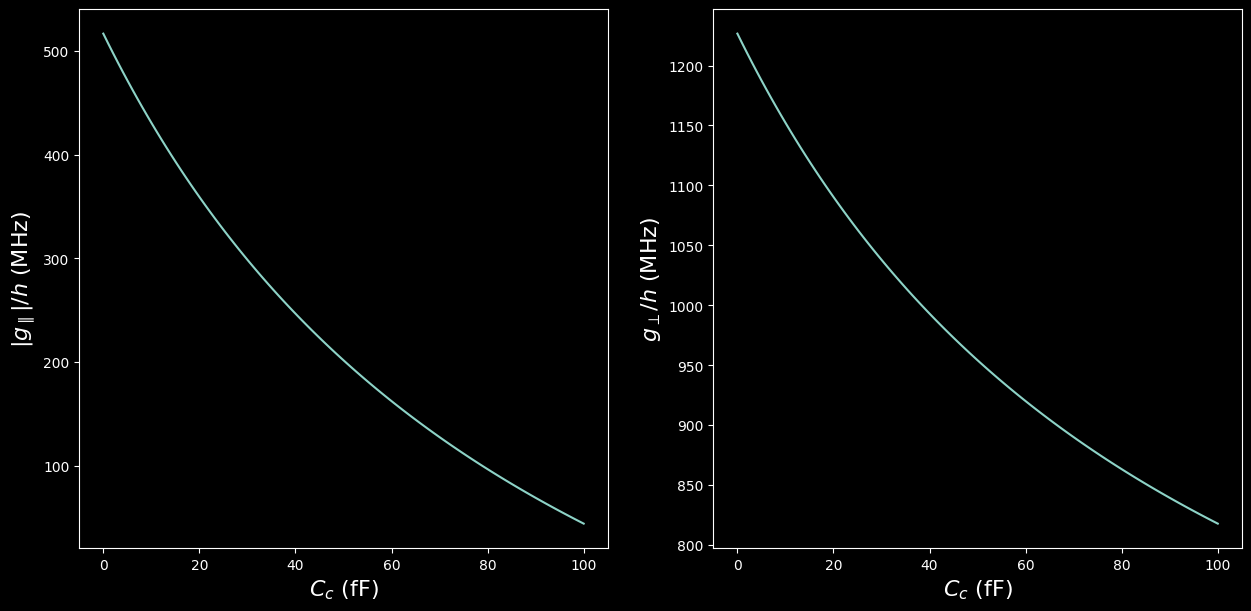

In [12]:
Ccs = np.linspace(0, 10e-14, 100)

fig_data_gparr = []
fig_data_gperp = []

for Cc in tqdm(Ccs):
    system_6.Cc = Cc

    # Full Hamiltonina Approach
    g_parr = system_6.get_g_parr(update=True)
    g_perp = system_6.get_g_perp()
    fig_data_gparr.append(g_parr)
    fig_data_gperp.append(g_perp)

pparam = dict(xlabel='$C_c$ (fF)', ylabel='$| g_\parallel | / h$ (MHz)')

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Ccs], [np.abs(g_parr) * 1e-6 / h for g_parr in fig_data_gparr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)
    pparam = dict(xlabel='$C_c$ (fF)', ylabel='$g_\\perp / h$ (MHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in Ccs], [np.abs(g_parr) * 1e-6 / h for g_parr in fig_data_gperp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)

    plt.show()

##### Varying Ej

In [20]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 1.2e-15
Ej_p = 9e9
Ej_t = 4e9
Cp = 150e-15
Ct = 300e-15
ncut_p = 20
ncut_t = 20

# Creation of circuit object
system_7 = circuit_cap(Cc, ng, [transmon(Ej_p, Cp, ng, ncut_p), transmon(Ej_t, Ct, ng, ncut_t)])

system_7.print_params()

Ejp:    9.000000000000002 GHz
Ec:    0.12810998230594658 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 70.25213678124317
w_probe:    4.162827012380807 GHz
Ejt:    4.000000000000001 GHz
Ec:    0.06431019032091344 GHz
Cjt:    300.0 fF
Ejt/Ect target: 62.198540853940145
w_target:    1.962215221868962 GHz
detunning:    2.2006117905118443 GHz
Cc:    1.2 fF
ng:    0.5


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Baptiste\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


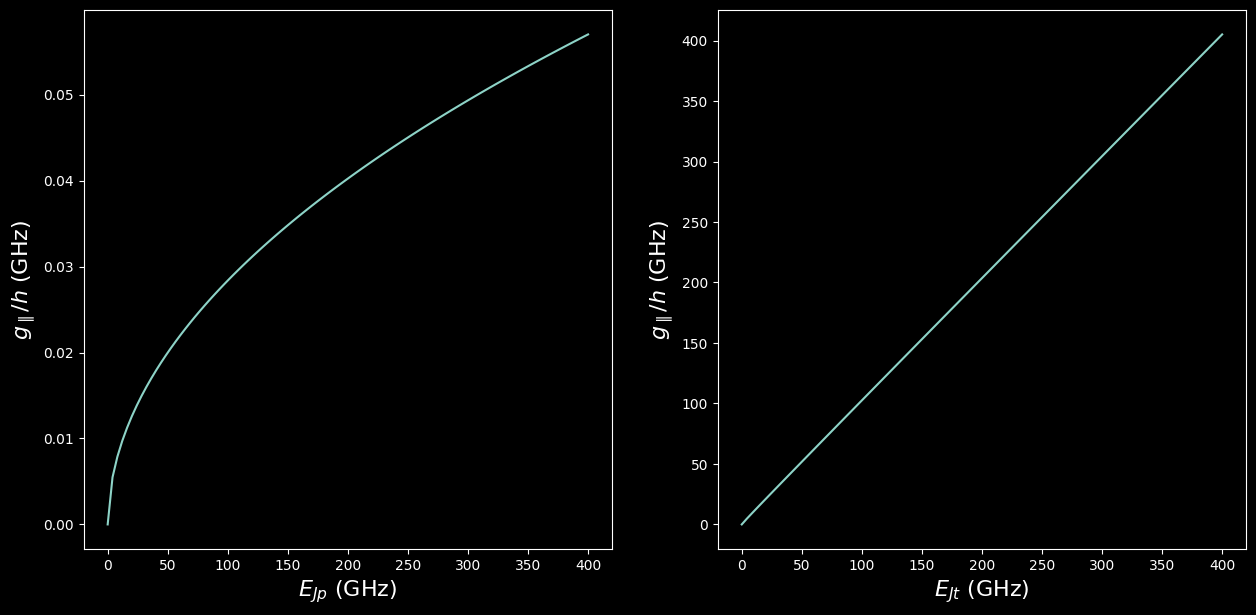

In [21]:
Ejps = np.linspace(0, 400e9, 100)
fig_data_Ejp_g_parr = []
Ejts = np.linspace(0, 400e9, 100)
fig_data_Ejt_g_parr = []

for Ejp in tqdm(Ejps):
    system_6.probe.Ej = Ejp*h
    
    g_parr = system_6.get_g_parr(update=True)
    fig_data_Ejp_g_parr.append(g_parr)
    
system_6.probe.Ej = 120e9
for Ejt in tqdm(Ejts):
    system_6.target.Ej = Ejt*h

    g_parr = system_6.get_g_parr(update=True)
    fig_data_Ejt_g_parr.append(g_parr)

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    pparam = dict(xlabel='$E_{Jp}$ (GHz)', ylabel='$g_\\parallel / h$ (GHz)')
    ax1.plot([val * 1e-9 for val in Ejps], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_data_Ejp_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)
    pparam = dict(xlabel='$E_{Jt}$ (GHz)', ylabel='$g_\\parallel / h$ (GHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e-9 for val in Ejts], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_data_Ejt_g_parr])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)

    plt.show()

##### Varying Ct and Cp

In [24]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 1.2e-15
Ej_p = 9e9
Ej_t = 4e9
Cp = 150e-15
Ct = 300e-15
ncut_p = 20
ncut_t = 20

# Creation of circuit object
system_8 = circuit_cap(Cc, ng, [transmon(Ej_p, Cp, ng, ncut_p), transmon(Ej_t, Ct, ng, ncut_t)])

system_8.print_params()

Ejp:    9.000000000000002 GHz
Ec:    0.12810998230594658 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 70.25213678124317
w_probe:    4.162827029536946 GHz
Ejt:    4.000000000000001 GHz
Ec:    0.06431019032091344 GHz
Cjt:    300.0 fF
Ejt/Ect target: 62.198540853940145
w_target:    1.9622152218689781 GHz
detunning:    2.2006118076679684 GHz
Cc:    1.2 fF
ng:    0.5


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Baptiste\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


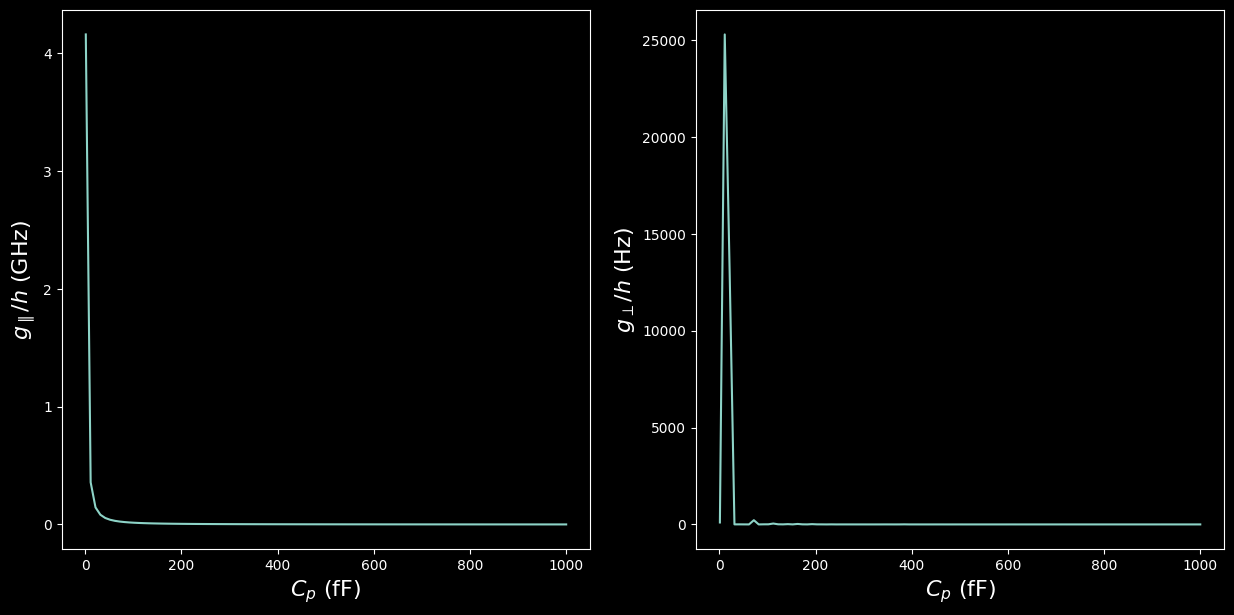

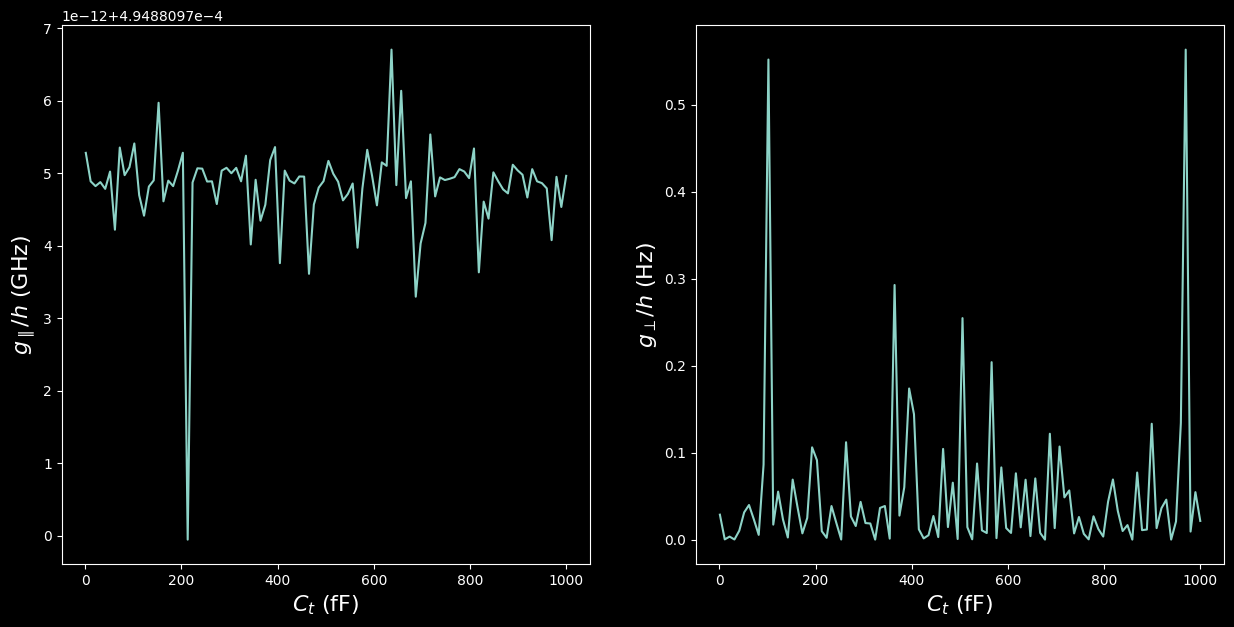

In [25]:
Cps = np.linspace(1e-15, 10e-13, 100)
fig_pt_detuning_Cp_g_parr = []
fig_pt_detuning_Cp_g_perp = []
fig_pt_detuning_Ct = np.linspace(1e-15, 10e-13, 100)
fig_pt_detuning_Ct_g_parr = []
fig_pt_detuning_Ct_g_perp = []

for Cp in tqdm(Cps):
    system_8.probe.C = Cp

    g_parr = system_8.get_g_parr(update=True)
    fig_pt_detuning_Cp_g_parr.append(g_parr)
    
    g_perp = system_8.get_g_perp()
    fig_pt_detuning_Cp_g_perp.append(g_perp)

system_5.probe.C = 12e-15

for Ct in tqdm(fig_pt_detuning_Ct):
    system_8.target.C = Ct

    g_parr = system_8.get_g_parr(update=True)
    fig_pt_detuning_Ct_g_parr.append(g_parr)
    
    g_perp = system_8.get_g_perp()
    fig_pt_detuning_Ct_g_perp.append(g_perp)

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    pparam = dict(xlabel='$C_{p}$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Cps], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Cp_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)

    pparam = dict(xlabel='$C_{p}$ (fF)', ylabel='$g_\\perp / h$ (Hz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in Cps], [np.abs(g_perp) / h for g_perp in fig_pt_detuning_Cp_g_perp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)
    plt.show()

pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ct_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)

    pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_\\perp / h$ (Hz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(g_perp) / h for g_perp in fig_pt_detuning_Ct_g_perp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)
    plt.show()

#### 2.4 Coupling strength regardeing detunning for Cc for g around 100 Mhz

- Cc made for g around 100Mhz
- ratio of around 70 for probe and the target can go to the charge basis
- 5ghz of energy for probe
- Shift of detuning from 0 detunning to 2ghz target below probe

In [7]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 20e-15
Ej_p = 9e9
Cp = 150e-15

# 2 detunning
Ej_t = 10e9
Ct = 170e-15

#0 detunning
# Ej_t = 4e9
# Ct = 300e-15

ncut_p = 20
ncut_t = 20
# Creation of circuit object
system_9 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], ng, ncut_t)])

system_9.print_params()
print('g_parr = ', system_9.get_g_parr() * 1e-9/ constants.h, 'GHz')


Ejp:    9.000000000000002 GHz
Ecp:    0.12913486216439415 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 69.69458014012218
w_probe:    2.913887570345378 GHz
ng probe:    0.5
Ejt:    9.999999999999998 GHz
Ec:    0.11394252543917131 GHz
Cjt:    170.0 fF
Ejt/Ect target: 87.76354536163534
w_target:    2.900433626533278 GHz
ng target:    0.5
detunning:    0.01345394381209986 GHz
Cc:    20.0 fF
g_parr =  0.8256370546669154 GHz


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


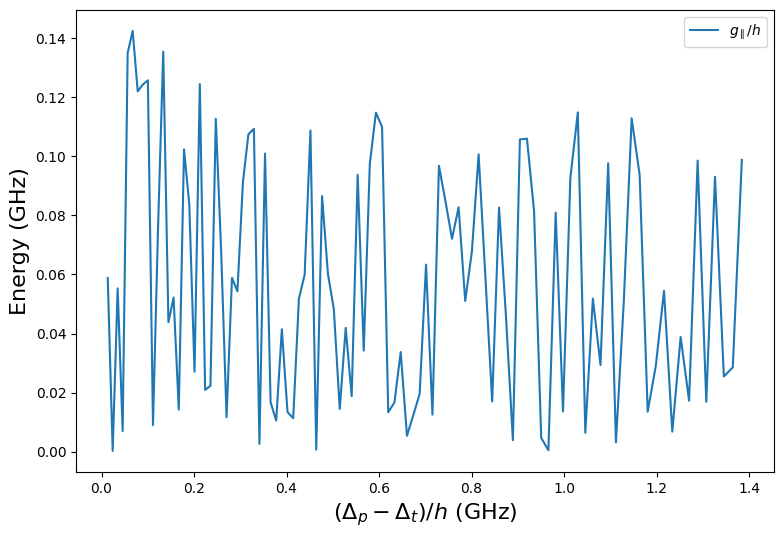

In [8]:
# fig_pt_detuning_Ejt = np.linspace(8.5e9, 27e9, 20)
fig_pt_detuning_Ejt = np.linspace(3e9, 10e9, 100)
fig_pt_detuning_Ejt_g_parr = []
fig_pt_detuning_Ejt_delta_t = []
fig_pt_detuning_Ejt_delta_t_bare = []
fig_pt_detuning_Ejt_delta_p = []



for Ejt in tqdm(fig_pt_detuning_Ejt):
    system_9.target.Ej = Ejt * h

    # Full Hamiltonina Approach
    g_parr = system_9.get_gparr2(update=True)
    fig_pt_detuning_Ejt_g_parr.append(g_parr)
    
    delta_t = system_9.get_omega_target()
    fig_pt_detuning_Ejt_delta_t.append(delta_t)
    
    delta_p = system_9.get_omega_probe()
    fig_pt_detuning_Ejt_delta_p.append(delta_p)

pparam = dict(xlabel='$(\\Delta_p - \\Delta_t) / h$ (GHz)', ylabel='Energy (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot([(np.abs(fig_pt_detuning_Ejt_delta_p[idx]) - np.abs(fig_pt_detuning_Ejt_delta_t[idx])) * 1e-9 / h for idx in range(len(fig_pt_detuning_Ejt))], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ejt_g_parr], label='$g_\parallel / h$')
    ax.set(**pparam)
    plt.legend()
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()   

---

### 3 Second method to compute the coupling


Ejp:    9.000000000000002 GHz
Ecp:    0.12913486216439415 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 69.69458014012218
w_probe:    2.9138875699855924 GHz
ng probe:    0.5
Ejt:    8.000000000000002 GHz
Ec:    0.11394252543917131 GHz
Cjt:    170.0 fF
Ejt/Ect target: 70.21083628930828
w_target:    2.5810467481970663 GHz
ng target:    0
detunning:    0.33284082178852603 GHz
Cc:    1.2 fF


100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


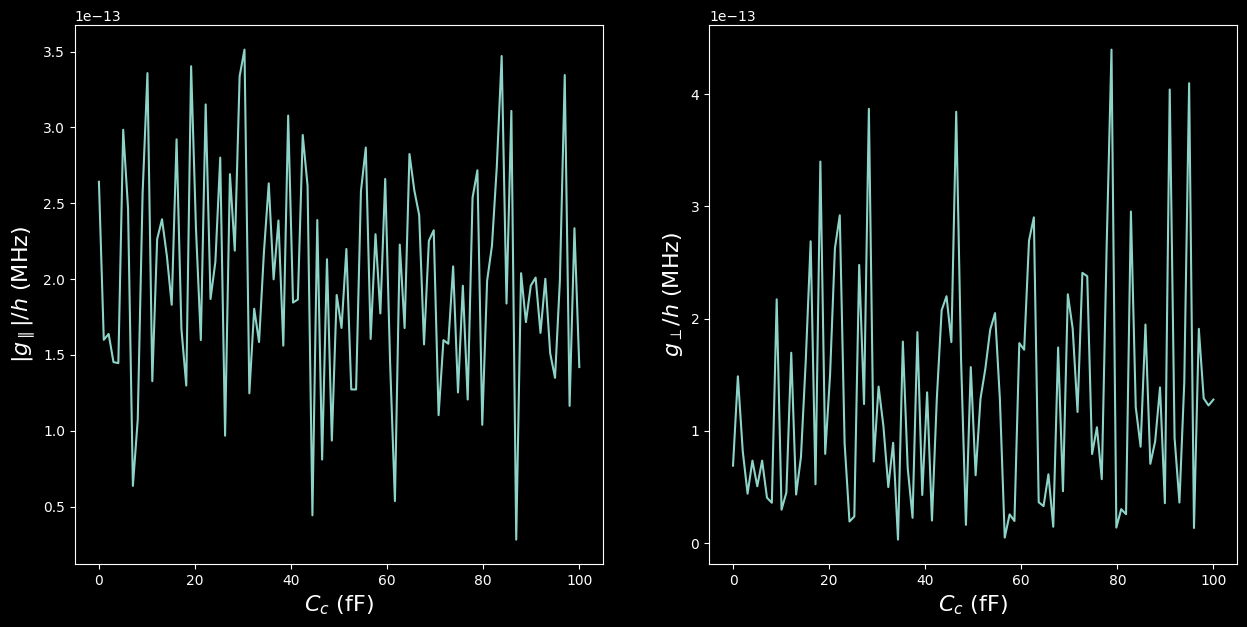

In [13]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 1.2e-15
Ej_p = 9e9
Ej_t = 8e9
Cp = 150e-15
Ct = 170e-15
ncut_p = 10
ncut_t = 10

# Creation of circuit object
system_10 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], 0, ncut_t)])

system_10.print_params()

Ccs = np.linspace(0, 10e-14, 100)

fig_data_gparr = []
fig_data_gperp = []

for Cc in tqdm(Ccs):
    system_10.Cc = Cc

    # Full Hamiltonina Approach
    g_parr = system_10.get_gparr2(update=True)
    g_perp = system_10.get_gperp2()
    fig_data_gparr.append(g_parr)
    fig_data_gperp.append(g_perp)

pparam = dict(xlabel='$C_c$ (fF)', ylabel='$| g_\parallel | / h$ (MHz)')

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Ccs], [np.abs(g_parr) * 1e-6 / h for g_parr in fig_data_gparr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)
    pparam = dict(xlabel='$C_c$ (fF)', ylabel='$g_\\perp / h$ (MHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in Ccs], [np.abs(g_parr) * 1e-6 / h for g_parr in fig_data_gperp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)

    plt.show()

### 4 Working in the charge basis

##### Varying Cc


Ejp:    9.000000000000002 GHz
Ecp:    0.12913486216439415 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 69.69458014012218
w_probe:    2.9138875699824016 GHz
ng probe:    0.5
Ejt:    8.000000000000002 GHz
Ec:    0.11394252543917131 GHz
Cjt:    170.0 fF
Ejt/Ect target: 70.21083628930828
w_target:    2.5810465724595764 GHz
ng target:    0.5
detunning:    0.33284099752282537 GHz
Cc:    1.2 fF


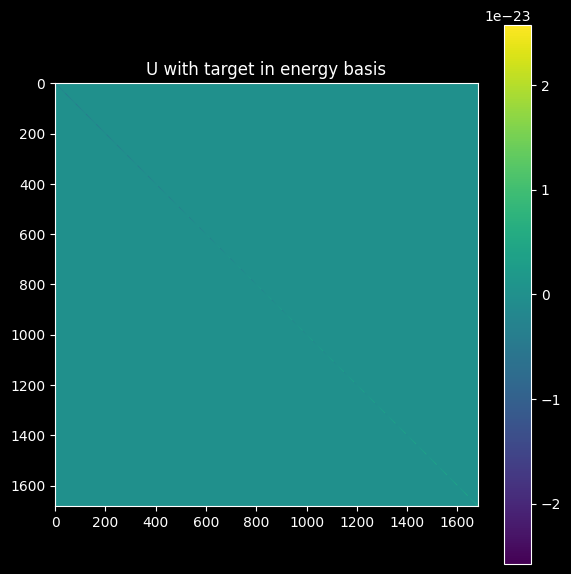

In [2]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 1.2e-15
Ej_p = 9e9
Ej_t = 8e9
Cp = 150e-15
Ct = 170e-15
ncut_p = 20
ncut_t = 20

# Creation of circuit object
system_11 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], ng, ncut_t)])

system_11.print_params()

# U_ebcb = system_2.get_U_circuit()[0]
U_ebeb = system_11.get_U_cb()

# U_ebeb = U_ebeb.toarray()
# U_ebcb = U_ebcb.toarray()

# U_ebeb = U_ebeb.astype(float)
# U_ebcb = U_ebcb.astype(float)

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('U with target in energy basis')
im1 = ax1.imshow(U_ebeb, cmap=plt.get_cmap(thememap))
f.colorbar(im1)

# ax2 = f.add_subplot(122)
# ax2.title.set_text('U with target in charge basis')
# im2 = ax2.imshow(U_ebcb, cmap=plt.get_cmap(thememap))
# f.colorbar(im2)

ax1.grid(False)
# ax2.grid(False)

plt.show()

Ejp:    9.000000000000002 GHz
Ecp:    0.12913486216439415 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 69.69458014012218
w_probe:    2.9138875699855924 GHz
ng probe:    0.5
Ejt:    8.000000000000002 GHz
Ec:    0.11394252543917131 GHz
Cjt:    170.0 fF
Ejt/Ect target: 70.21083628930828
w_target:    2.5810467481970663 GHz
ng target:    0
detunning:    0.33284082178852603 GHz
Cc:    1.2 fF


100%|██████████| 100/100 [00:28<00:00,  3.45it/s]


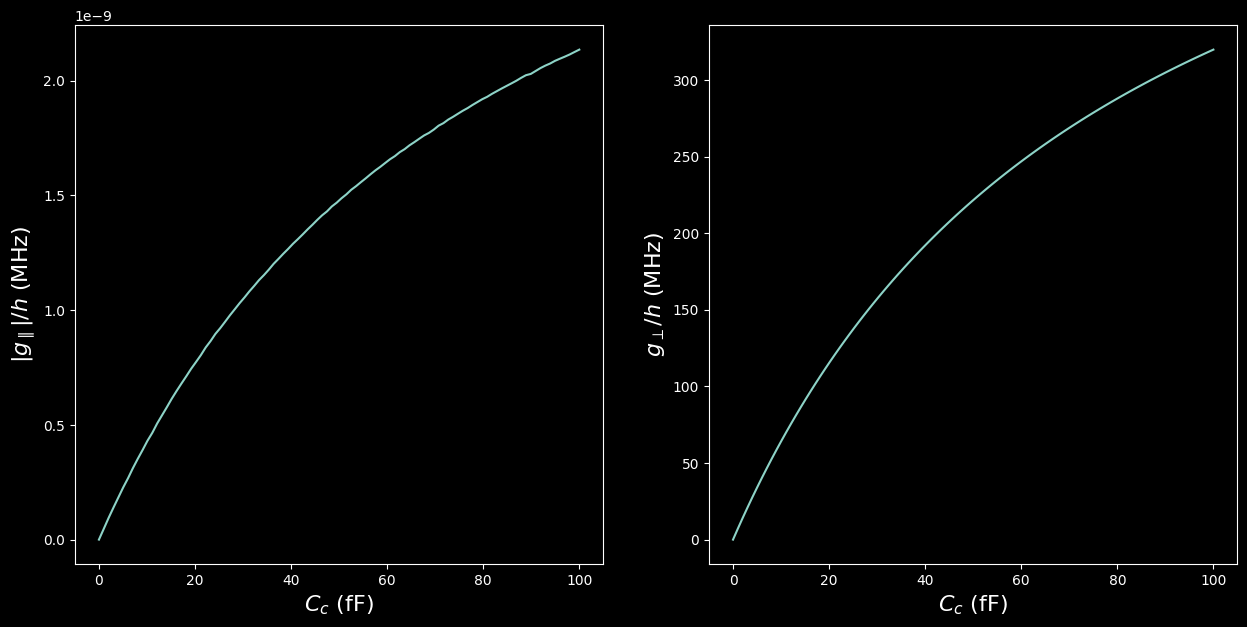

In [7]:
# Initialize transmon

# Circuit constant
ng = 0
Cc = 1.2e-15
Ej_p = 9e9
Ej_t = 8e9
Cp = 150e-15
Ct = 170e-15
ncut_p = 10
ncut_t = 10

# Creation of circuit object
system_12 = circuit_cap(Cc, [qubit(Ej_p, [Cp], 0.5, ncut_p), qubit(Ej_t, [Ct], ng, ncut_t)])

system_12.print_params()

Ccs = np.linspace(0, 10e-14, 100)

fig_data_gparr = []
fig_data_gperp = []

for Cc in tqdm(Ccs):
    system_12.Cc = Cc

    # Full Hamiltonina Approach
    g_parr = system_12.get_g_parr_cb(update=True)
    g_perp = system_12.get_g_perp_cb()
    fig_data_gparr.append(g_parr)
    fig_data_gperp.append(g_perp)

pparam = dict(xlabel='$C_c$ (fF)', ylabel='$| g_\parallel | / h$ (MHz)')

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Ccs], [np.abs(g_parr) * 1e-6 / h for g_parr in fig_data_gparr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)
    pparam = dict(xlabel='$C_c$ (fF)', ylabel='$g_\\perp / h$ (MHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in Ccs], [np.abs(g_parr) * 1e-6 / h for g_parr in fig_data_gperp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)

    plt.show()

##### Varying Ej


Ejp:    9.000000000000002 GHz
Ecp:    0.12913486216439415 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 69.69458014012218
w_probe:    2.9138875699855924 GHz
ng probe:    0.5
Ejt:    8.000000000000002 GHz
Ec:    0.11394252543917131 GHz
Cjt:    170.0 fF
Ejt/Ect target: 70.21083628930828
w_target:    2.5810467481970663 GHz
ng target:    0
detunning:    0.33284082178852603 GHz
Cc:    20.0 fF


100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


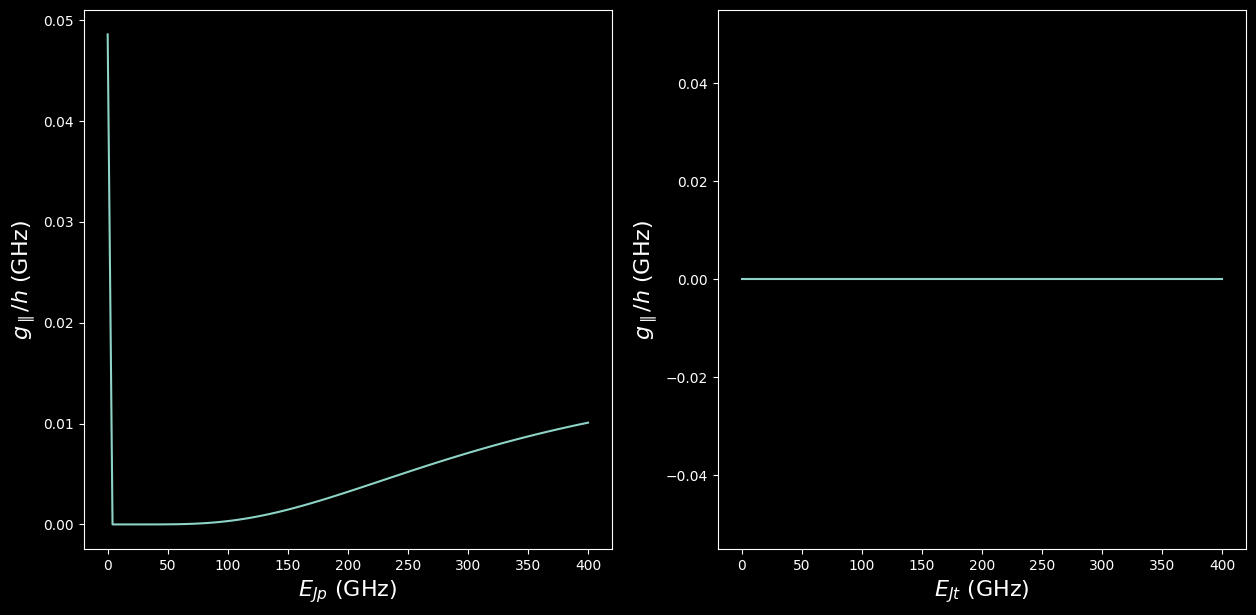

In [17]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 20e-15
Ej_p = 9e9
Ej_t = 8e9
Cp = 150e-15
Ct = 170e-15
ncut_p = 10
ncut_t = 10

# Creation of circuit object
system_4 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], 0, ncut_t)])

system_4.print_params()

Ejps = np.linspace(0, 400e9, 100)
fig_data_Ejp_g_parr = []
Ejts = np.linspace(0, 400e9, 100)
fig_data_Ejt_g_parr = []

for Ejp in tqdm(Ejps):
    system_4.probe.Ej = Ejp*h
    
    g_parr = system_4.get_g_parr_cb(update=True)
    fig_data_Ejp_g_parr.append(g_parr)
    
system_4.probe.Ej = 120e9
for Ejt in tqdm(Ejts):
    system_4.target.Ej = Ejt*h

    g_parr = system_4.get_g_parr_cb(update=True)
    fig_data_Ejt_g_parr.append(g_parr)

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    pparam = dict(xlabel='$E_{Jp}$ (GHz)', ylabel='$g_\\parallel / h$ (GHz)')
    ax1.plot([val * 1e-9 for val in Ejps], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_data_Ejp_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)
    pparam = dict(xlabel='$E_{Jt}$ (GHz)', ylabel='$g_\\parallel / h$ (GHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e-9 for val in Ejts], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_data_Ejt_g_parr])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)

    plt.show()

Ejp:    9.000000000000002 GHz
Ecp:    0.12913486216439415 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 69.69458014012218
w_probe:    2.9138875699855924 GHz
ng probe:    0.5
Ejt:    8.000000000000002 GHz
Ec:    0.11394252543917131 GHz
Cjt:    170.0 fF
Ejt/Ect target: 70.21083628930828
w_target:    2.5810467481970663 GHz
ng target:    0
detunning:    0.33284082178852603 GHz
Cc:    20.0 fF


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


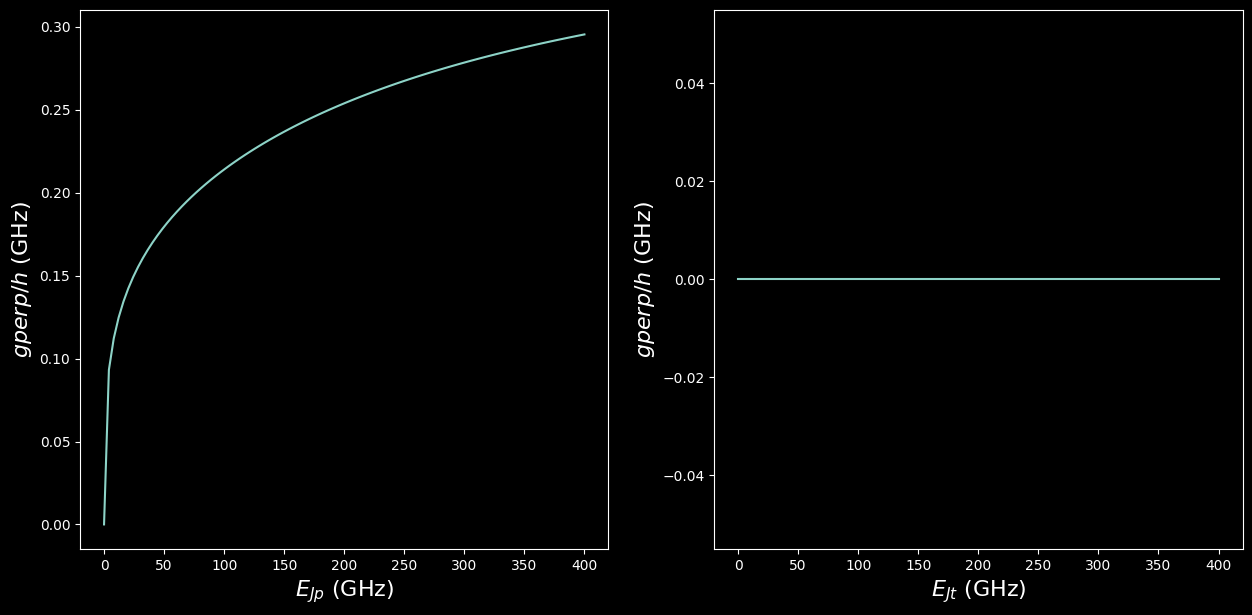

In [19]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 20e-15
Ej_p = 9e9
Ej_t = 8e9
Cp = 150e-15
Ct = 170e-15
ncut_p = 10
ncut_t = 10

# Creation of circuit object
system_4 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], 0, ncut_t)])

system_4.print_params()

Ejps = np.linspace(0, 400e9, 100)
fig_data_Ejp_g_parr = []
Ejts = np.linspace(0, 400e9, 100)
fig_data_Ejt_g_parr = []

for Ejp in tqdm(Ejps):
    system_4.probe.Ej = Ejp*h
    
    g_parr = system_4.get_g_perp_cb(update=True)
    fig_data_Ejp_g_parr.append(g_parr)
    
system_4.probe.Ej = 120e9
for Ejt in tqdm(Ejts):
    system_4.target.Ej = Ejt*h

    g_parr = system_4.get_g_perp_cb(update=True)
    fig_data_Ejt_g_parr.append(g_parr)

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    pparam = dict(xlabel='$E_{Jp}$ (GHz)', ylabel='$g perp / h$ (GHz)')
    ax1.plot([val * 1e-9 for val in Ejps], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_data_Ejp_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)
    pparam = dict(xlabel='$E_{Jt}$ (GHz)', ylabel='$g perp / h$ (GHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e-9 for val in Ejts], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_data_Ejt_g_parr])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)

    plt.show()

##### Varying Ct and Cp

In [ ]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 20e-15
Ej_p = 9e9
Ej_t = 8e9
Cp = 150e-15
Ct = 170e-15
ncut_p = 10
ncut_t = 10

# Creation of circuit object
system_5 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], 0, ncut_t)])

system_5.print_params()

Cps = np.linspace(1e-15, 10e-13, 100)
fig_pt_detuning_Cp_g_parr = []
fig_pt_detuning_Cp_g_perp = []
fig_pt_detuning_Ct = np.linspace(1e-15, 10e-13, 100)
fig_pt_detuning_Ct_g_parr = []
fig_pt_detuning_Ct_g_perp = []

for Cp in tqdm(Cps):
    system_5.probe.C = Cp

    g_parr = system_5.get_g_parr_cb(update=True)
    fig_pt_detuning_Cp_g_parr.append(g_parr)
    
    g_perp = system_5.get_g_perp_cb()
    fig_pt_detuning_Cp_g_perp.append(g_perp)

system_5.probe.C = 12e-15

for Ct in tqdm(fig_pt_detuning_Ct):
    system_5.target.C = Ct

    g_parr = system_5.get_g_parr_cb(update=True)
    fig_pt_detuning_Ct_g_parr.append(g_parr)
    
    g_perp = system_5.get_g_perp_cb()
    fig_pt_detuning_Ct_g_perp.append(g_perp)

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    pparam = dict(xlabel='$C_{p}$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Cps], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Cp_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)

    pparam = dict(xlabel='$C_{p}$ (fF)', ylabel='$g_\\perp / h$ (Hz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in Cps], [np.abs(g_perp) / h for g_perp in fig_pt_detuning_Cp_g_perp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)
    plt.show()

pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ct_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)

    pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_\\perp / h$ (Hz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(g_perp) / h for g_perp in fig_pt_detuning_Ct_g_perp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)
    plt.show()

#### Varying detunning

Ejp:    9.000000000000002 GHz
Ecp:    0.12913486216439415 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 69.69458014012218
w_probe:    2.9138875699855924 GHz
ng probe:    0.5
Ejt:    9.999999999999998 GHz
Ec:    0.11394252543917131 GHz
Cjt:    170.0 fF
Ejt/Ect target: 87.76354536163534
w_target:    2.9004336265829926 GHz
ng target:    0.5
detunning:    0.013453943402599934 GHz
Cc:    20.0 fF


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


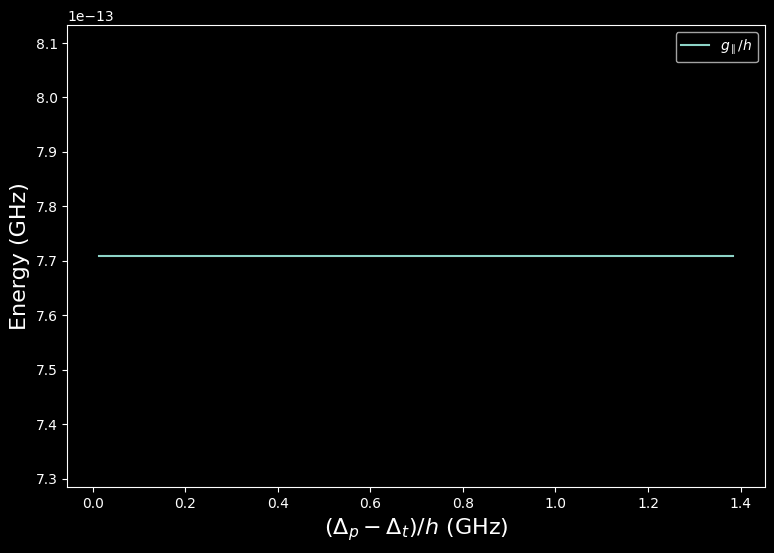

In [21]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 20e-15
Ej_p = 9e9
Cp = 150e-15

# 2 detunning
Ej_t = 10e9
Ct = 170e-15

#0 detunning
# Ej_t = 4e9
# Ct = 300e-15

ncut_p = 10
ncut_t = 10
# Creation of circuit object
system_9 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], ng, ncut_t)])

system_9.print_params()

# fig_pt_detuning_Ejt = np.linspace(8.5e9, 27e9, 20)
fig_pt_detuning_Ejt = np.linspace(3e9, 10e9, 100)
fig_pt_detuning_Ejt_g_parr = []
fig_pt_detuning_Ejt_delta_t = []
fig_pt_detuning_Ejt_delta_t_bare = []
fig_pt_detuning_Ejt_delta_p = []



for Ejt in tqdm(fig_pt_detuning_Ejt):
    system_9.target.Ej = Ejt * h

    # Full Hamiltonina Approach
    g_parr = system_9.get_g_parr_cb(update=True)
    fig_pt_detuning_Ejt_g_parr.append(g_parr)
    
    delta_t = system_9.get_omega_target()
    fig_pt_detuning_Ejt_delta_t.append(delta_t)
    
    delta_p = system_9.get_omega_probe()
    fig_pt_detuning_Ejt_delta_p.append(delta_p)

pparam = dict(xlabel='$(\\Delta_p - \\Delta_t) / h$ (GHz)', ylabel='Energy (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot([(np.abs(fig_pt_detuning_Ejt_delta_p[idx]) - np.abs(fig_pt_detuning_Ejt_delta_t[idx])) * 1e-9 / h for idx in range(len(fig_pt_detuning_Ejt))], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ejt_g_parr], label='$g_\parallel / h$')
    ax.set(**pparam)
    plt.legend()
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()   

Ejp:    9.000000000000002 GHz
Ecp:    0.12913486216439415 GHz
Cjp:    150.0 fF
Ejp/Ecp probe: 69.69458014012218
w_probe:    2.9138875699855924 GHz
ng probe:    0.5
Ejt:    9.999999999999998 GHz
Ec:    0.11394252543917131 GHz
Cjt:    170.0 fF
Ejt/Ect target: 87.76354536163534
w_target:    2.9004336265829926 GHz
ng target:    0.5
detunning:    0.013453943402599934 GHz
Cc:    20.0 fF


100%|██████████| 100/100 [00:53<00:00,  1.85it/s]


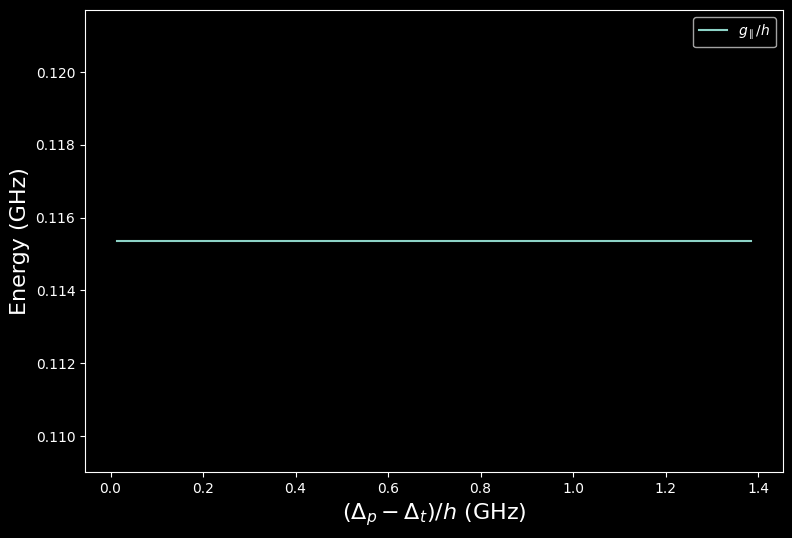

In [22]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 20e-15
Ej_p = 9e9
Cp = 150e-15

# 2 detunning
Ej_t = 10e9
Ct = 170e-15

#0 detunning
# Ej_t = 4e9
# Ct = 300e-15

ncut_p = 10
ncut_t = 10
# Creation of circuit object
system_9 = circuit_cap(Cc, [qubit(Ej_p, [Cp], ng, ncut_p), qubit(Ej_t, [Ct], ng, ncut_t)])

system_9.print_params()

# fig_pt_detuning_Ejt = np.linspace(8.5e9, 27e9, 20)
fig_pt_detuning_Ejt = np.linspace(3e9, 10e9, 100)
fig_pt_detuning_Ejt_g_parr = []
fig_pt_detuning_Ejt_delta_t = []
fig_pt_detuning_Ejt_delta_t_bare = []
fig_pt_detuning_Ejt_delta_p = []



for Ejt in tqdm(fig_pt_detuning_Ejt):
    system_9.target.Ej = Ejt * h

    # Full Hamiltonina Approach
    g_parr = system_9.get_g_perp_cb(update=True)
    fig_pt_detuning_Ejt_g_parr.append(g_parr)
    
    delta_t = system_9.get_omega_target()
    fig_pt_detuning_Ejt_delta_t.append(delta_t)
    
    delta_p = system_9.get_omega_probe()
    fig_pt_detuning_Ejt_delta_p.append(delta_p)

pparam = dict(xlabel='$(\\Delta_p - \\Delta_t) / h$ (GHz)', ylabel='Energy (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot([(np.abs(fig_pt_detuning_Ejt_delta_p[idx]) - np.abs(fig_pt_detuning_Ejt_delta_t[idx])) * 1e-9 / h for idx in range(len(fig_pt_detuning_Ejt))], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ejt_g_parr], label='$g_\parallel / h$')
    ax.set(**pparam)
    plt.legend()
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()  